# Libraries and s3 connexion

In [2]:
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 51.2 MB/s eta 0:00:00


In [83]:
import numpy as np
import h5py
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

In [84]:
fs = s3fs.S3FileSystem(
    client_kwargs={"endpoint_url": f'https://{os.environ["AWS_S3_ENDPOINT"]}'},
    key=os.environ["AWS_ACCESS_KEY_ID"],
    secret=os.environ["AWS_SECRET_ACCESS_KEY"],
    token=os.environ["AWS_SESSION_TOKEN"],
)

# Load data

In [96]:
# Initialiser le système de fichiers S3
def download_s3_folder(fs, bucket_name, s3_folder, local_dir):
    """
    Télécharge tous les fichiers d'un dossier S3 dans un répertoire local.
    
    :param bucket_name: Nom du bucket S3.
    :param s3_folder: Chemin du dossier sur S3 à télécharger.
    :param local_dir: Chemin local où télécharger les fichiers.
    """
    # Liste des fichiers dans le dossier S3
    files = fs.ls(f"{bucket_name}/{s3_folder}")

    for file in files:
        file_path = file.replace(bucket_name+s3_folder, "")
        local_file_path = os.path.join(local_dir, file_path)

        # Créer les répertoires locaux si nécessaire
        local_file_dir = os.path.dirname(local_file_path)
        if not os.path.exists(local_file_dir):
            os.makedirs(local_file_dir)

        # Télécharger le fichier
        print(f"Téléchargement de {file} vers {local_file_path}")
        fs.get(file, local_file_path)

# Exemples d'utilisation
bucket_name = 'projet-slums-detection/'
s3_folder = 'challenge_mexique/'
local_dir = 'satellite-images-challenge-human-settlements/data/'

download_s3_folder(fs, bucket_name, s3_folder, local_dir)


Téléchargement de projet-slums-detection/challenge_mexique/.keep vers satellite-images-challenge-human-settlements/data/.keep
Téléchargement de projet-slums-detection/challenge_mexique/SampleSubmission.csv vers satellite-images-challenge-human-settlements/data/SampleSubmission.csv
Téléchargement de projet-slums-detection/challenge_mexique/id_map.csv vers satellite-images-challenge-human-settlements/data/id_map.csv
Téléchargement de projet-slums-detection/challenge_mexique/test_data.h5 vers satellite-images-challenge-human-settlements/data/test_data.h5
Téléchargement de projet-slums-detection/challenge_mexique/train_data.h5 vers satellite-images-challenge-human-settlements/data/train_data.h5


OSError: [Errno 28] No space left on device

## Train data

In [20]:
# Path to your HDF5 file
hdf5_file = "data/train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])
    
    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)


/tmp/ipykernel_889/308163644.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X = np.array(hdf['images'])


Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)


/tmp/ipykernel_889/308163644.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y = np.array(hdf['labels'])


### Visualize first image (uint16)

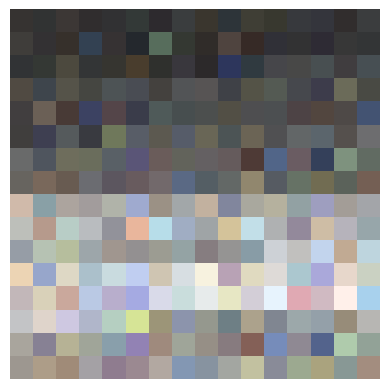

In [47]:
# plot l'image 50
image_array = X[50]

rgb_image = np.stack([image_array[:, :, 0], image_array[:, :, 1], image_array[:, :, 2]], axis=-1)

# Normalize the image for display (optional if values exceed standard 8-bit range)
rgb_image_normalized = rgb_image / np.max(rgb_image)

# Plot the RGB image
plt.imshow(rgb_image_normalized)
plt.axis('off')
plt.show()

## Test data

In [48]:
hdf5_file_test = "data/test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

/tmp/ipykernel_889/3349114931.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_test = np.array(hdf['images'])


Shape of X_test (images): (120000, 16, 16, 6)


### Create y_test

In [62]:
mapping = pd.read_csv("data/id_map.csv")

In [63]:
sample = pd.read_csv("data/SampleSubmission.csv")

In [75]:
y_test = pd.merge(sample, mapping, on="id")
y_test = y_test.sort_values(by="ID", ascending=True)
y_test = y_test.reset_index(drop=True)
y_test = np.array(y_test['class'])

### Balance data

In [80]:
def balance_data(X, y, prop_of_zeros=0.2):
    # Step 1: Count the number of 1's in y
    num_ones = np.sum(y == 1)
    
    # Step 2: Get indices of 0's and 1's in y
    ones_indices = np.where(y == 1)[0]
    zeros_indices = np.where(y == 0)[0]
    
    # Step 3: Randomly sample the same number of 0's as there are 1's
    balanced_zero_indices = np.random.choice(zeros_indices, int(int(num_ones)*prop_of_zeros), replace=False)
    
    # Step 4: Combine indices of 0's and 1's
    balanced_indices = np.concatenate([ones_indices, balanced_zero_indices])
    
    # Step 5: Create balanced X and y
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    # Display the number of 0's and 1's in the balanced y
    print(f"Number of 1's in balanced y: {np.sum(y_balanced == 1)}")
    print(f"Number of 0's in balanced y: {np.sum(y_balanced == 0)}")

    # Shuffle both X_balanced and y_balanced together
    X_train, y_train = shuffle(X_balanced, y_balanced, random_state=1)

    return X_train, y_train

In [81]:
X_train, y_train = balance_data(X, y)

Number of 1's in balanced y: 100000
Number of 0's in balanced y: 20000


In [82]:
print(X_train.shape)
print(X_test.shape)

(120000, 16, 16, 6)
(120000, 16, 16, 6)


### Baseline models
#### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1)  

# Define and train the baseline model
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_flat, y_train)

y_pred_train = rf.predict(X_train_flat)
y_pred_test = rf.predict(X_test_flat)


# Evaluate the model
train_accuracy_rf = accuracy_score(y_train, y_pred_train)

## 0.9999 accuracy: OVERFITTING
print(f'Baseline RF model training accuracy: {train_accuracy_rf:.4f}')


Baseline RF model training accuracy: 0.9999


#### Multi layer perceptron

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the data to [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Define and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_train_mlp = mlp_model.predict(X_train_scaled)
y_pred_test_mlp = mlp_model.predict(X_test_scaled)


# Evaluate the model
train_accuracy_mlp = accuracy_score(y_train, y_pred_train_mlp)


## ~0.60 accuracy: UNDERFITTING
print(f'Baseline MLP model training accuracy: {train_accuracy_mlp:.4f}')




/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline MLP model training accuracy: 0.6053
